In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

生成モデルのパラメータ設定

In [2]:
D = 2 # 観測変数の次元
M = 1 # 潜在変数の次元
sample_size = 300
I_M = np.identity(M)
I_D = np.identity(D)

W_gen = np.array([
    [5.],
    [2.]
]).reshape(D, M)
mu_gen = np.array([
    [3.],
    [4.]
]).reshape(D, 1)
sigma_gen = 2.

サンプルデータ生成，プロット

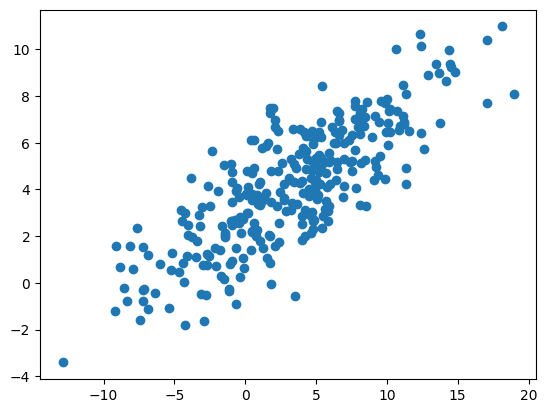

In [3]:
z = multivariate_normal(np.zeros((M, 1)), I_M).rvs(size=sample_size).reshape(-1, M)
x = []
for n in range(z.shape[0]):
    x_mean = (W_gen @ z[n,:].reshape(M, -1) + mu_gen).flatten()
    x.append(multivariate_normal(x_mean, sigma_gen*I_D).rvs())
x = np.array(x)
plt.scatter(x[:,0], x[:,1])
plt.show()

EMアルゴリズム

In [4]:
# EMのパラメータ設定
T = 100
EPSILON = 0.01

In [5]:
def E_step(x, W, mu, sigma):
    mat_M = W.T @ W + sigma*I_M
    M_inv = LA.inv(mat_M)
    z_expect = []
    z_cov_expect = []
    for n in range(x.shape[0]):
        Ez = M_inv @ (W.T @ (x[n,:] - mu).reshape(D, -1)).flatten()
        z_expect.append(Ez)
        z_cov_expect.append(sigma * M_inv + Ez @ Ez.T)
    return np.array(z_expect), np.array(z_cov_expect)

In [6]:
def M_step(x, mu, z_expect, z_cov_expect):
    W1 = np.array([[0. for _ in range(M)] for _ in range(D)])
    W2 = z_cov_expect.sum(axis=0)
    for n in range(x.shape[0]):
        W1 += (x[n,:] - mu).reshape(D, -1) @ z_expect[n,:].reshape(-1, M)
    W_new = W1 @ LA.inv(W2)

    sigma_new = 0.
    for n in range(x.shape[0]):
        xn = (x[n,:] - mu).reshape(D, -1)
        sigma_new += xn.T @ xn
        sigma_new -= 2 * z_expect[n,:].reshape(-1, M) @ W_new.T @ xn
        sigma_new += np.trace(z_cov_expect[n,:,:] @ W_new.T @ W_new)
    sigma_new /= (x.shape[0]*D)

    return W_new, float(sigma_new)

In [12]:
def EM(x):
    mu_est = x.mean(axis=0)
    W_est = np.array([1.]*(D*M)).reshape(D, M)
    sigma_est = 1.

    for t in range(T):
        z_expect, z_cov_expect = E_step(x, W_est, mu_est, sigma_est)
        W_new, sigma_new = M_step(x, mu_est, z_expect, z_cov_expect)

        W_est = W_new
        sigma_est = sigma_new

    return mu_est, W_est, sigma_est

In [14]:
mu_est, W_est, sigma_est = EM(x)
print(f"estimated mean:\n{mu_est.reshape(D, -1)}")
print(f"estimated W:\n{W_est}")
print(f"estimated sigma: {sigma_est}")

/var/folders/51/y1mms50s6t55s4g8dhd1mh3m0000gn/T/ipykernel_6604/3562239905.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return W_new, float(sigma_new)


estimated mean:
[[3.2840877 ]
 [4.17897376]]
estimated W:
[[5.36569305]
 [2.18319271]]
estimated sigma: 2.07402840847818
